In [2]:
import geopandas as gpd
from geopandas.tools import overlay
import os
import matplotlib.pyplot as plt
import boto3

def reproject_clip_geospatial(directory, input_folder, output_root_folder):
    
    '''
    Loops through geospatial datasets from a folder, identifies each sets coordinate reference system (crs), and reprojects them
    to the Census tract data crs (EPSG:4269). Files are then clipped for the Census tract boundaries, visualized, and uploaded to 
    Amazon Web Services (AWS) as .shp and .shx files for future analysis.

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
    
    Parameters
    ----------
    directory: string
        AWS directory in which final data will be uploaded to
        
    input_folder: string
        Folder with geospatial datasets
        
    output_root_folder: string
        Folder to store subfolders containing the data
    '''
    
    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  
    
    ca_boundaries = gpd.read_file('ca_tract_tiger')
    print(f'Target CRS for all files: {ca_boundaries.crs}')
    print('')

    os.makedirs(output_root_folder, exist_ok=True)

    # Iterate through each subfolder in the root folder
    for subfolder_name in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder_name)

        # Check if the item is a directory
        if os.path.isdir(subfolder_path):
            # Create a subfolder for each input subfolder in the output folder
            output_subfolder = os.path.join(output_root_folder, f"{subfolder_name}_clipped")
            os.makedirs(output_subfolder, exist_ok=True)
            
            # Iterate through each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.shp'):
                    input_file_path = os.path.join(subfolder_path, filename)

                    # Read the GeoDataFrame
                    gdf = gpd.read_file(input_file_path)

                    # Print the current CRS
                    print(f"Original CRS of {filename}: {gdf.crs}")
                    
                    # Create subplots for each iteration
                    ax = plt.subplot(111)
                    
                    # Plot the clipped GeoDataFrame
                    gdf.plot(ax=ax)
                    
                    # Set the title
                    plt.title(f"Original data from {filename}")

                    # Show the plot for each iteration
                    plt.show()
                    
                    # Reproject to 'ca_boundaries'
                    gdf_reprojected = gdf.to_crs(ca_boundaries.crs)

                    # Clip using 'ca_boundaries'
                    clipped_gdf = overlay(gdf_reprojected, ca_boundaries, how='intersection')
                    print(f"New CRS of {filename}: {clipped_gdf.crs}")
                    print('')

                    # Save the reprojected and clipped GeoDataFrame to the output subfolder
                    output_file_path_shp = os.path.join(output_subfolder, f"clipped_{filename}")
                    clipped_gdf.to_file(output_file_path_shp)

                    # Upload the .shp file to AWS S3
                    with open(output_file_path_shp, 'rb') as data_shp:
                        s3_client.upload_fileobj(data_shp, bucket_name, f"{directory}_clipped/{filename}")
                        print(f'{filename} (shp) successfully uploaded to AWS')

                    # Find the corresponding .shx file
                    shx_filename = filename.replace('.shp', '.shx')
                    input_file_path_shx = os.path.join(subfolder_path, shx_filename)

                    if os.path.exists(input_file_path_shx):
                        # Upload the .shx file to AWS S3
                        output_file_path_shx = os.path.join(output_subfolder, f"clipped_{shx_filename}")
                        with open(input_file_path_shx, 'rb') as data_shx:
                            s3_client.upload_fileobj(data_shx, bucket_name, f"{directory}_clipped/{shx_filename}")
                            print(f'{shx_filename} successfully uploaded to AWS')

                    # Create subplots for each iteration
                    ax = plt.subplot(111)
                    
                    # Plot the clipped GeoDataFrame
                    clipped_gdf.plot(ax=ax)
                    
                    # Set the title
                    plt.title(f"Clipped and Reprojected {filename}")

                    # Show the plot for each iteration
                    plt.show()

    # Close the figure after the loop
    plt.close()

Target CRS for all files: EPSG:4269

Original CRS of CellularTowers.shp: EPSG:3857


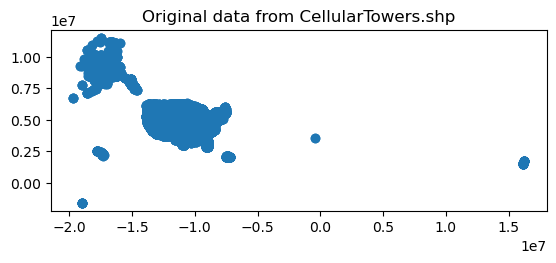

New CRS of CellularTowers.shp: EPSG:4269

CellularTowers.shp (shp) successfully uploaded to AWS
CellularTowers.shx successfully uploaded to AWS


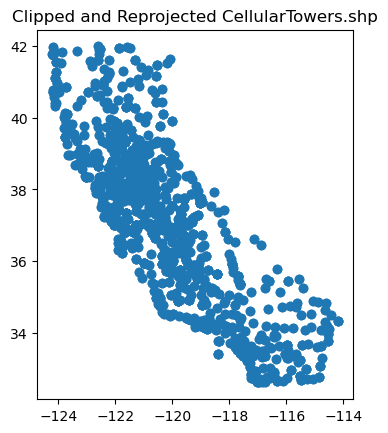

Original CRS of FM_TransTowers.shp: EPSG:3857


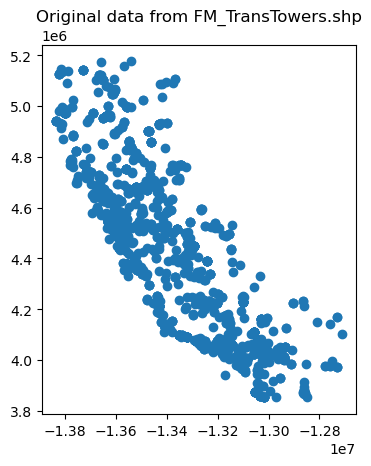

New CRS of FM_TransTowers.shp: EPSG:4269

FM_TransTowers.shp (shp) successfully uploaded to AWS
FM_TransTowers.shx successfully uploaded to AWS


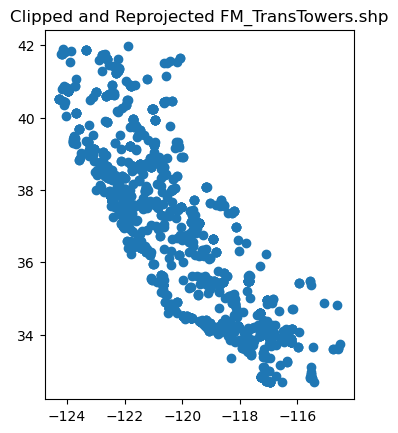

Original CRS of Land_Mobile_Broadcast_Towers.shp: EPSG:4326


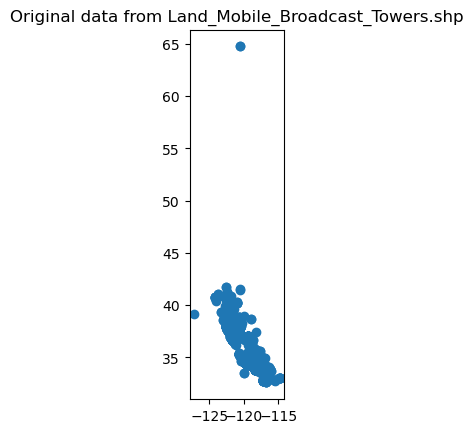

New CRS of Land_Mobile_Broadcast_Towers.shp: EPSG:4269

Land_Mobile_Broadcast_Towers.shp (shp) successfully uploaded to AWS
Land_Mobile_Broadcast_Towers.shx successfully uploaded to AWS


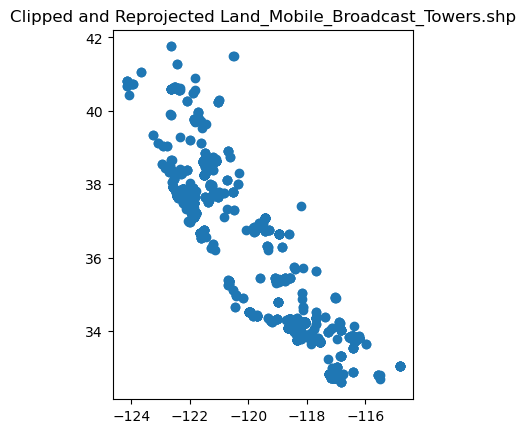

Original CRS of Microwave_Service_Towers.shp: EPSG:4326


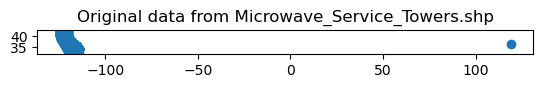

New CRS of Microwave_Service_Towers.shp: EPSG:4269

Microwave_Service_Towers.shp (shp) successfully uploaded to AWS
Microwave_Service_Towers.shx successfully uploaded to AWS


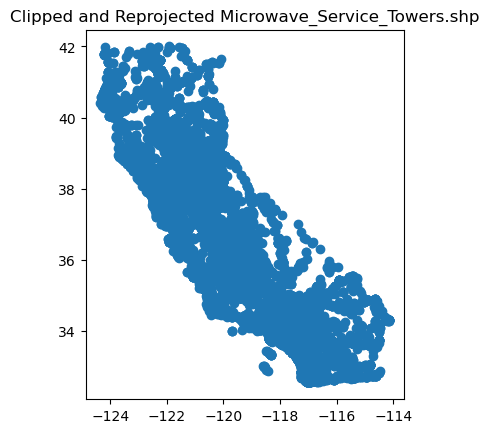

Original CRS of Paging_Transmission_Towers.shp: EPSG:4326


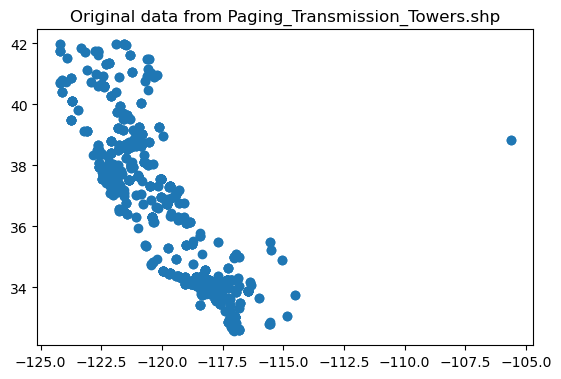

New CRS of Paging_Transmission_Towers.shp: EPSG:4269

Paging_Transmission_Towers.shp (shp) successfully uploaded to AWS
Paging_Transmission_Towers.shx successfully uploaded to AWS


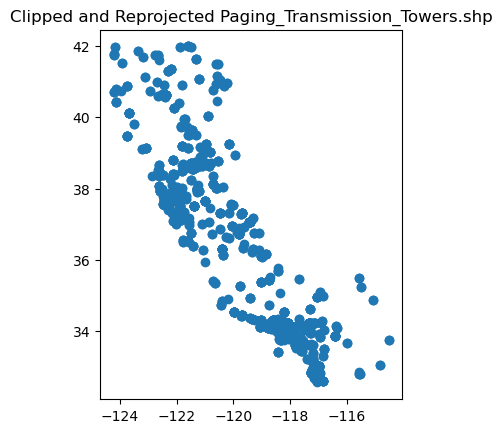

Original CRS of TV_DigitalStationTransmitters.shp: EPSG:3857


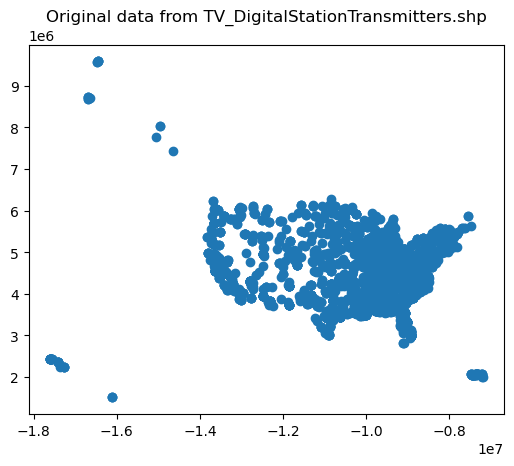

New CRS of TV_DigitalStationTransmitters.shp: EPSG:4269

TV_DigitalStationTransmitters.shp (shp) successfully uploaded to AWS
TV_DigitalStationTransmitters.shx successfully uploaded to AWS


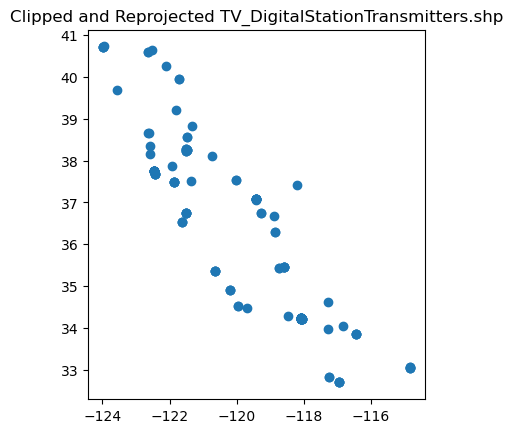

In [3]:
input_folder = 'hifl_communication'
output_root_folder = 'communication_clipped_ca'
directory = '2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data'

reproject_clip_geospatial(directory, input_folder, output_root_folder)

### Verifying files uploaded to AWS were subsetted and clipped

<Axes: >

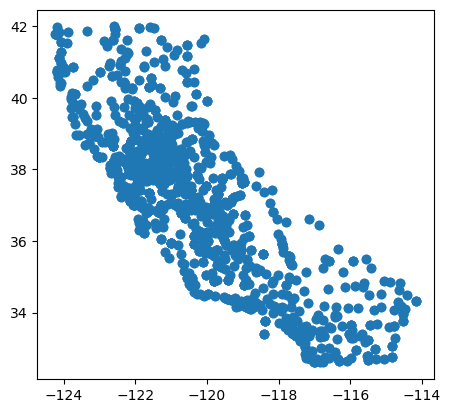

In [5]:
gdf = gpd.read_file('CellularTowers.shp')

ax = plt.subplot(111)
                    
gdf.plot(ax=ax)